In [1]:
# === SYSTEM-CHECK & IMPORTS ===
# Dieser Block importiert alle notwendigen Bibliotheken und prüft die Systemumgebung.

# os: Interaktion mit dem Betriebssystem (Pfade, Ordner erstellen)
# sys: System-spezifische Parameter und Funktionen (z.B. Python-Version)
# json: Zum Lesen und Schreiben von JSON-Dateien (Konfigurationen)
# time: Zeitfunktionen (z.B. für Zeitstempel im Manifest)
# hashlib: Zum Erstellen von Hash-Werten (Prüfsummen) für Dateien
# platform: Informationen über die zugrunde liegende Plattform (Betriebssystem)
import os, sys, json, time, hashlib, platform

# Path: Objektorientierte Behandlung von Dateipfaden (moderner als os.path)
from pathlib import Path

# numpy (np): Numerische Berechnungen, Arrays, mathematische Funktionen
import numpy as np

# pandas (pd): Datenanalyse und -manipulation (DataFrames für Tabellendaten)
import pandas as pd

# matplotlib.pyplot (plt): Erstellen von Diagrammen und Visualisierungen
import matplotlib.pyplot as plt

# Wir geben die aktuelle Python-Version aus, um sicherzustellen, dass die Umgebung korrekt ist.
print("Python:", sys.version)

# Wir geben das Betriebssystem aus (z.B. Windows, Linux).
print("OS:", platform.platform())

# Wir versuchen, TensorFlow zu importieren, um zu prüfen, ob es installiert ist und GPUs erkannt werden.
try:
    # TensorFlow importieren (Machine Learning Bibliothek)
    import tensorflow as tf
    # Version ausgeben und Anzahl der verfügbaren GPUs anzeigen
    print("tensorflow:", tf.__version__, "| GPUs:", len(tf.config.list_physical_devices('GPU')))
except Exception as e:
    # Falls TensorFlow nicht installiert ist oder ein Fehler auftritt, geben wir diesen aus.
    print("TF-Check:", e)

Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26200-SP0
tensorflow: 2.10.0 | GPUs: 1


In [2]:
# === KONFIGURATION LADEN ===
# Dieser Abschnitt lädt die zentralen Einstellungen für das Projekt.

# Wir ermitteln den absoluten Pfad zum übergeordneten Verzeichnis ("..").
# Das dient als Wurzelverzeichnis (Root) für relative Pfade.
ROOT = os.path.abspath("..")

# Wir prüfen, ob dieser Root-Pfad bereits in den Python-Systempfaden enthalten ist.
# Falls nicht, fügen wir ihn an erster Stelle hinzu, damit wir eigene Module importieren können.
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

# Wir öffnen die Konfigurationsdatei "config.json" im Lesemodus ("r").
# Diese Datei enthält Parameter wie Ticker, Startdatum, Enddatum usw.
with open(os.path.join(ROOT, "config.json"), "r") as f:
    # Wir laden den Inhalt der JSON-Datei in das Dictionary 'C'.
    C = json.load(f)

# Nun entpacken wir die wichtigsten Parameter aus dem Dictionary in einzelne Variablen.
# Das verbessert die Lesbarkeit des Codes im weiteren Verlauf.

TICKER   = C["ticker"]       # Das Börsenkürzel des Assets (z.B. "AAPL").
START    = C["start"]        # Startdatum für die historischen Daten (YYYY-MM-DD).
END      = C["end"]          # Enddatum für die historischen Daten (YYYY-MM-DD).
INTERVAL = C["interval"]     # Zeitintervall der Datenpunkte (z.B. "1d" für täglich).

# Die folgenden Werte werden als Integer (Ganzzahlen) interpretiert.
HORIZON  = int(C["horizon"]) # Vorhersage-Horizont: Wie viele Schritte in die Zukunft wollen wir vorhersagen?
LOOKBACK = int(C["lookback"])# Rückblick-Fenster: Wie viele vergangene Zeitschritte nutzen wir als Input?
BATCH    = int(C["batch"])   # Batch-Größe: Wie viele Datensätze werden gleichzeitig trainiert?
EPOCHS   = int(C["epochs"])  # Epochen: Wie oft soll das Modell den gesamten Datensatz sehen?
SEED     = int(C.get("seed", 42)) # Zufalls-Seed für Reproduzierbarkeit (Standard: 42).

# Wir definieren den Pfad für das Ergebnis-Verzeichnis.
# Falls 'results_dir' nicht in der Config steht, nutzen wir "../results" als Standard.
RESULTS_DIR = Path(C.get("results_dir", "../results"))

# Wir erstellen das Verzeichnis, falls es noch nicht existiert (parents=True erstellt auch übergeordnete Ordner).
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Wir erstellen sicherheitshalber auch das Daten-Verzeichnis "../data".
os.makedirs("../data", exist_ok=True)

# Wir definieren den Dateinamen für die rohe CSV-Datei, basierend auf Ticker, Intervall und Zeitraum.
RAW_CSV = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"

In [3]:
# === DATEN-DOWNLOAD & BEREINIGUNG ===
# Hier laden wir die Finanzdaten herunter und bringen sie in ein sauberes Format.

# Wir importieren yfinance, eine Bibliothek zum Abrufen von Daten von Yahoo Finance.
import yfinance as yf

# Wir laden die Daten für den konfigurierten Ticker und Zeitraum herunter.
# auto_adjust=True: Bereinigt Preise um Splits und Dividenden.
# group_by="column": Gruppiert die Daten spaltenweise (besser für Einzel-Ticker).
# threads=False, progress=False: Deaktiviert Multithreading und Ladebalken für saubereren Output.
df = yf.download(
    TICKER, start=START, end=END, interval=INTERVAL,
    auto_adjust=True, group_by="column", threads=False, progress=False
)

# Manchmal liefert yfinance einen MultiIndex (verschachtelte Spalten) zurück.
# Wir müssen sicherstellen, dass wir eine flache, einfache Tabelle haben.
if isinstance(df.columns, pd.MultiIndex):
    # Wir holen uns die obere und untere Ebene der Spaltennamen
    top  = df.columns.get_level_values(0).str.lower()
    bot  = df.columns.get_level_values(1).str.lower()
    
    # Wir prüfen, auf welcher Ebene die relevanten Spalten (open, close etc.) stehen.
    if {"open","high","low","close","adj close","volume"} & set(bot):
        # Wenn sie unten stehen, nehmen wir die untere Ebene.
        df.columns = df.columns.get_level_values(1)
    elif {"open","high","low","close","adj close","volume"} & set(top):
        # Wenn sie oben stehen, nehmen wir die obere Ebene.
        df.columns = df.columns.get_level_values(0)
    else:
        # Falls nur eine Ebene da ist und es unklar ist:
        if len(set(top)) == 1:
            df.columns = df.columns.get_level_values(1)
        else:
            # Wenn wir die Struktur nicht erkennen, werfen wir einen Fehler.
            raise RuntimeError(f"Unbekannte MultiIndex-Struktur: {list(df.columns)})")

# Wir vereinheitlichen die Spaltennamen: alles kleinschreiben und Leerzeichen entfernen.
# So wird aus "Adj Close" -> "adjclose" und aus "Open" -> "open".
df = df.rename(columns=lambda c: str(c).strip().lower().replace(" ",""))

# Falls wir nur 'adjclose' haben aber kein 'close', nutzen wir 'adjclose' als 'close'.
if "close" not in df.columns and "adjclose" in df.columns:
    df["close"] = df["adjclose"]

# Wir stellen sicher, dass der Index (das Datum) sauber als Datetime-Objekt formatiert ist.
# errors="coerce": Ungültige Daten werden zu NaT (Not a Time).
df.index = pd.to_datetime(df.index, errors="coerce")

# Wir zählen, ob es doppelte Zeitstempel gibt (Duplikate im Index).
dup_count = int(df.index.duplicated().sum())

# Wir entfernen Zeilen, wo der Index NaT (leer/ungültig) ist, und sortieren nach Datum aufsteigend.
df = df[~df.index.isna()].sort_index()

# Wir definieren die Spalten, die zwingend vorhanden sein müssen.
required = {"open","high","low","close","volume"}
# Wir prüfen, ob Spalten fehlen.
missing  = required - set(df.columns)
if missing:
    # Wenn etwas fehlt, geben wir die vorhandenen Spalten aus und stoppen mit Fehler.
    print("Spalten gefunden:", list(df.columns))
    raise KeyError(f"Fehlende Pflichtspalten nach Normalisierung: {sorted(missing)}")

# Wir stellen sicher, dass alle numerischen Spalten auch wirklich Zahlen enthalten.
# Nicht-numerische Werte werden zu NaN (Not a Number).
for c in required.union({"adjclose"}):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Wir löschen alle Zeilen, die in den Pflichtspalten NaN-Werte (Lücken) haben.
df = df.dropna(subset=list(required), how="any")

In [4]:
# === CHECK: SIND DIE DATEN OK? ===
# Kurze Überprüfung der Datenqualität vor dem Speichern.

# Wenn der DataFrame leer ist, hat der Download nicht geklappt.
if df.empty:
    raise ValueError("Download ergab keine Daten. Ist das Intervall/Datum ok? Rate-Limit?")

# Doppelte Zeitstempel dürfen in Zeitreihen nicht vorkommen, da sie die Reihenfolge stören.
if df.index.has_duplicates:
    raise ValueError("Duplicate timestamps gefunden.")

# Erfolgsmeldung mit den finalen Spaltennamen.
print("Spalten final:", df.columns.tolist())
# Ausgabe des Zeitraums und der Anzahl der Datenpunkte (n).
print("Zeitraum:", df.index.min().date(), "→", df.index.max().date(), "| n =", len(df))

Spalten final: ['close', 'high', 'low', 'open', 'volume']
Zeitraum: 2010-01-04 → 2025-12-31 | n = 4024


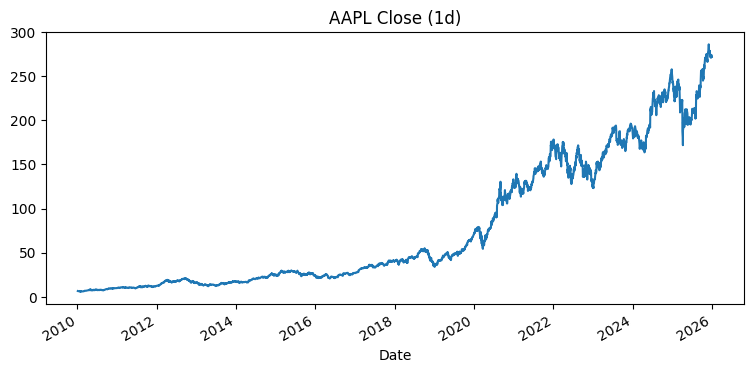

In [5]:
# === PLOTTING ===
# Ein visueller Check, um grobe Fehler in den Daten sofort zu erkennen.

# Wir plotten die 'close'-Spalte (Schlusskurs).
# Titel enthält Ticker und Intervall, Bildgröße ist 9x4 Zoll.
df["close"].plot(title=f"{TICKER} Close ({INTERVAL})", figsize=(9,4))

# Anzeigen des Plots.
plt.show()
# Schließen des Plots, um Speicher freizugeben.
plt.close()

In [6]:
# === SPEICHERN ===
# Die bereinigten Rohdaten werden jetzt auf die Festplatte geschrieben.
# Das dient als definierter Startpunkt für alle weiteren Schritte (Feature Engineering).

# Der Pfad wurde oben in RAW_CSV definiert.
csv_path = RAW_CSV

# Wir speichern als CSV. float_format="%.8f" sorgt für hohe Präzision bei Kommazahlen.
df.to_csv(csv_path, float_format="%.8f")

# Bestätigungsausgabe mit dem Speicherort.
print("CSV gespeichert unter:", csv_path)

CSV gespeichert unter: ../data/AAPL_1d_2010-01-01_2026-01-01.csv


In [7]:
# === METADATEN & PROFILING ===
# Wir erstellen Metadaten zur Datei, um Änderungen nachverfolgen zu können (Data Versioning).

# Hilfsfunktion zum Berechnen eines SHA256-Hashs einer Datei.
# Der Hash ist wie ein digitaler Fingerabdruck des Dateiinhalts.
def _sha256_file(path, chunk=1<<20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            # Wir lesen die Datei stückweise (Chunk für Chunk).
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

# Wir ermitteln die Zeitzonen-Info des Index, falls vorhanden.
tz_info = getattr(df.index, "tz", None)
tz_name = str(tz_info) if tz_info is not None else "naive"

# Das Manifest speichert, WAS wir geladen haben und WIE die Datei aussieht.
manifest = {
    "ticker": TICKER, "interval": INTERVAL, "start": START, "end": END,
    "rows": int(len(df)), # Anzahl der Zeilen
    "first_ts": str(df.index.min()), # Erster Zeitstempel
    "last_ts": str(df.index.max()),  # Letzter Zeitstempel
    "sha256": _sha256_file(csv_path), # Der Hash der Datei
    "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()), # Erstellungszeitpunkt
    "tz": tz_name, # Zeitzone
    "source": "yfinance" # Datenquelle
}
# Wir speichern das Manifest als JSON-Datei.
with open("../data/DATA_MANIFEST.json", "w") as f:
    json.dump(manifest, f, indent=2)

# Das Profiling speichert statistische Kennzahlen der Rohdaten.
# Das hilft später, die Datenverteilung zu verstehen.
profiling = {
    "n": int(len(df)),
    "na_any": int(df.isna().any().any()), # Gibt es irgendwo NaNs? (Sollte 0 sein)
    "close_min": float(df["close"].min()), # Minimaler Preis
    "close_max": float(df["close"].max()), # Maximaler Preis
    # Log-Returns (logarithmische Renditen) sind statistisch oft aussagekräftiger als absolute Preise.
    # Wir berechnen den Durchschnitt und die Standardabweichung der Log-Returns.
    "logret_1d_mean": float(np.log(df["close"]).diff().dropna().mean()), 
    "logret_1d_std": float(np.log(df["close"]).diff().dropna().std()),   # Volatilität
    "dup_timestamps": dup_count, # Anzahl doppelter Zeitstempel
    "volume_zero_share": float((df["volume"]==0).mean()) # Anteil der Tage mit 0 Volumen
}
# Wir speichern das Profiling als JSON-Datei.
with open("../data/profiling.json", "w") as f:
    json.dump(profiling, f, indent=2)

print("Manifest & Profiling geschrieben.")

Manifest & Profiling geschrieben.


# -----------------------------------------------------------
# Block 2: Zielvariable bauen – Klassifikation (Up/Down)
# -----------------------------------------------------------
# Hier beginnt der zweite Teil des Notebooks.
# Ziel: Technische Indikatoren als Features berechnen und die Zielvariable (Label) erstellen.
# Das Label bestimmt, was das Modell lernen soll (z.B. "Steigt der Kurs morgen?").

In [8]:
# === SETUP FÜR LABELING ===
# Wir importieren erneut notwendige Module (falls dieser Teil separat ausgeführt wird).
import os, sys, json, yaml
from pathlib import Path
import numpy as np
import pandas as pd

# Root-Pfad setzen.
ROOT = os.path.abspath("..")
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

# Config laden, um Feature-Parameter zu erhalten.
with open(os.path.join(ROOT, "config.json"), "r") as f:
    C = json.load(f)

# Parameter extrahieren.
TICKER   = C["ticker"]
START    = C["start"]
END      = C["end"]
INTERVAL = C["interval"]
FEATURESET = C.get("featureset", "v2") # Welches Feature-Set soll genutzt werden? (Standard: v2)

# Parameter speziell für das Labeling (die Zielvariable):
HORIZON   = int(C.get("horizon", 5))    # Vorhersagehorizont: In wie vielen Tagen schauen wir den Preis an?
LOOKBACK  = int(C.get("lookback", 60))  # Input-Fenster: Wie viele Tage Historie bekommt das Modell?
# Epsilon-Mode: Wie wird der Schwellwert für "Up"/"Down" bestimmt?
# "abs": Absoluter Wert (z.B. > 0.0005 Log-Return)
# "quantile": Dynamisch basierend auf der Verteilung der Returns (z.B. Top 40%)
EPS_MODE  = str(C.get("epsilon_mode", "abs"))
EPSILON   = float(C.get("epsilon", 0.0005)) # Der Schwellwert selbst.

# Der Pfad zur CSV-Datei, die wir in Block 1 erstellt haben.
raw_csv_path = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"

In [9]:
# === DATEN WIEDER LADEN ===
# Falls dieser Block separat ausgeführt wird, müssen wir die Daten neu laden.
from finance_lstm import read_prices

# read_prices ist eine Hilfsfunktion (aus unserem Projekt), die das Laden und Parsen übernimmt.
df_raw = read_prices(raw_csv_path)

# Sicherheitscheck: Preise müssen positiv sein (keine negativen Kurse möglich).
assert (df_raw["close"] > 0).all()

In [10]:
# === FEATURE ENGINEERING (Die "Intelligenz" des Modells) ===
# Hier berechnen wir technische Indikatoren, die dem Modell helfen sollen, Muster zu erkennen.

# Hilfsfunktion zur Berechnung des RSI (Relative Strength Index).
# Der RSI misst die Geschwindigkeit und Veränderung von Preisbewegungen (Momentum).
def _rsi(close: pd.Series, n=14):
    # Tägliche Änderung des Schlusskurses.
    r = close.diff().fillna(0.0)
    # Aufteilung in Gewinne (up) und Verluste (dn).
    up  = r.clip(lower=0.0); dn = (-r).clip(lower=0.0)
    # Glättung der Gewinne und Verluste über n Perioden (Rolling Mean).
    roll_up = up.rolling(n, min_periods=n).mean()
    roll_dn = dn.rolling(n, min_periods=n).mean()
    # Berechnung der Relative Strength (RS).
    rs  = roll_up / (roll_dn + 1e-12) # +1e-12 verhindert Division durch Null.
    # Umwandlung in RSI (Skala 0-100).
    return 100.0 - (100.0 / (1.0 + rs))

# Hilfsfunktion zur Berechnung des MACD (Moving Average Convergence Divergence).
# Trendfolgender Momentum-Indikator.
def _macd(close: pd.Series, fast=12, slow=26, signal=9):
    # Exponentiell gleitender Durchschnitt (EMA) schnell (12 Perioden).
    ema_fast = close.ewm(span=fast, adjust=False, min_periods=fast).mean()
    # Exponentiell gleitender Durchschnitt (EMA) langsam (26 Perioden).
    ema_slow = close.ewm(span=slow, adjust=False, min_periods=slow).mean()
    # MACD-Linie ist die Differenz zwischen schnellem und langsamem EMA.
    macd = ema_fast - ema_slow
    # Signallinie ist der EMA der MACD-Linie (9 Perioden).
    macd_sig = macd.ewm(span=signal, adjust=False, min_periods=signal).mean()
    # MACD-Histogramm ist die Differenz zwischen MACD und Signallinie.
    return macd, macd_sig, macd - macd_sig

# Hauptfunktion zum Erstellen aller Features (Indikatoren).
def build_features_v2(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    
    # 1. Log-Returns (die wichtigste Basisgröße).
    # Log-Returns sind besser als prozentuale Änderungen, da sie additiv sind.
    out["logret_1d"] = np.log(out["close"]).diff()
    # Kumulierte Log-Returns über 3 und 5 Tage.
    out["logret_3d"] = out["logret_1d"].rolling(3,  min_periods=3).sum()
    out["logret_5d"] = out["logret_1d"].rolling(5,  min_periods=5).sum()
    
    # 2. Volatilität (Rolling Standard Deviation).
    # Misst die Schwankungsbreite der Returns über die letzten 10 Tage.
    out["realized_vol_10"] = out["logret_1d"].rolling(10, min_periods=10).std()
    
    # 3. Bollinger Bands Position.
    # Wo steht der Kurs relativ zu den Bollinger Bändern (SMA +- 2*Std)?
    sma20 = out["close"].rolling(20, min_periods=20).mean()
    std20 = out["close"].rolling(20, min_periods=20).std()
    out["bb_pos"] = (out["close"] - sma20) / (2.0*std20 + 1e-12)
    
    # 4. RSI (14 Perioden).
    out["rsi_14"] = _rsi(out["close"], 14)
    
    # 5. MACD Komponenten.
    macd, macd_sig, macd_diff = _macd(out["close"])
    out["macd"] = macd; out["macd_sig"] = macd_sig; out["macd_diff"] = macd_diff
    
    # 6. Volumen-Indikatoren (Z-Score des Log-Volumens).
    # Wir log-transformieren das Volumen, um Ausreißer zu dämpfen.
    out["log_vol"] = np.log(out["volume"].replace(0, np.nan))
    # Wir berechnen Median und Median Absolute Deviation (MAD) für Robustheit.
    roll_med = out["log_vol"].rolling(20, min_periods=20).median()
    roll_mad = out["log_vol"].rolling(20, min_periods=20).apply(
        lambda x: np.median(np.abs(x - np.median(x))), raw=True
    )
    # Z-Score ähnliche Normalisierung, begrenzt (clipped) auf +/- 10.
    out["vol_z_20"] = ((out["log_vol"] - roll_med) / (roll_mad + 1e-12)).clip(-10, 10)
    
    # 7. Trendstärke (SMA Diff).
    # Verhältnis von kurzfristigem (10) zu langfristigem (20) Durchschnitt.
    out["sma_diff"] = (out["close"].rolling(10, min_periods=10).mean() /
                       (out["close"].rolling(20, min_periods=20).mean() + 1e-12) - 1.0)
    return out

# Wir wenden die Feature-Funktion auf unsere Rohdaten an.
df_feat = build_features_v2(df_raw)

In [11]:
# === LABELING (Die Zielvariable für das Training) ===
# Hier definieren wir, was das Modell vorhersagen soll.

# Wir wollen vorhersagen: Steigt der Preis in H Tagen?
# Dazu berechnen wir den "Forward Log Return" (Zukunfts-Rendite).
fut = np.log(df_feat["close"]).shift(-HORIZON) # Der Preis in HORIZON Tagen (durch shift nach oben verschoben)
cur = np.log(df_feat["close"])                 # Der Preis heute
fwd_logret = fut - cur                          # Die Differenz ist der Return in der Zukunft

# Wir müssen aufpassen, dass wir keine Informationen aus der Zukunft für die Berechnung von Schwellwerten nutzen.
# Daher definieren wir Split-Indizes für Train/Validation/Test.
n_total = len(df_feat)
n_train = int(n_total * 0.70) # 70% Training
n_val   = int(n_total * 0.15) # 15% Validierung
train_idx = slice(0, n_train) # Slice für Trainingsdaten

# Threshold (Epsilon) bestimmen: Ab welchem Return nennen wir es "Steigen" (Klasse 1)?
if EPS_MODE == "quantile":
    # Dynamisch: Wir nehmen das X-te Quantil der Returns im Trainingsdatensatz.
    # z.B. 0.6 bedeutet: Die Top 40% der Returns gelten als "Up".
    q = EPSILON if 0 < EPSILON < 1 else 0.6
    eps_val = float(fwd_logret.iloc[train_idx].quantile(q))
    eps_mode_used = f"q{q:.2f}"
else:
    # Statisch: Ein fester absoluter Wert (z.B. 0.0005).
    # Alles was größer ist als dieser Wert, gilt als "Up".
    eps_val = float(EPSILON)
    eps_mode_used = "abs"

# Target Label setzen: 1 (Kaufen/Up) wenn Return > Epsilon, sonst 0 (Warten/Down).
df_feat["target"] = (fwd_logret > eps_val).astype("int8")

# Optionales Zusatzlabel: Volatilitäts-bereinigt.
# Prüft, ob der Return im Verhältnis zum aktuellen Risiko (Volatilität) gut ist.
z = fwd_logret / (df_feat["realized_vol_10"] + 1e-12)
df_feat["target_z"] = (z > 0.4).astype("int8")

# Durch Rolling Windows und Shifting entstehen am Anfang und Ende NaNs (leere Felder).
# Diese löschen wir jetzt.
df_clean = df_feat.dropna().sort_index()

In [12]:
# === PROFILING UPDATE ===
# Wir aktualisieren unser Profiling mit der Info, wie viele Datenpunkte nach der Verarbeitung noch da sind.
# Das hilft zu sehen, wie viele Daten wir durch das Windowing "verloren" haben.
prof_path = Path("../data/profiling.json")
try:
    # Altes Profiling laden, falls vorhanden.
    profiling = json.load(open(prof_path, "r")) if prof_path.exists() else {}
except Exception:
    profiling = {}

# Neuen Wert eintragen.
profiling["n_after_dropna_features"] = int(len(df_clean))

# Wieder speichern.
with open(prof_path, "w") as f:
    json.dump(profiling, f, indent=2)

In [13]:
# === FEATURE DOKUMENTATION ===
# Eine saubere Dokumentation der verwendeten Features ist wichtig für die Reproduzierbarkeit.
# Wir speichern eine Liste der Features und eine Beschreibung in einer YAML-Datei.

features_list = [
    "logret_1d","logret_3d","logret_5d",
    "realized_vol_10","bb_pos","rsi_14",
    "macd","macd_sig","macd_diff",
    "vol_z_20","sma_diff",
]

# Dokumentation für jedes Feature (was bedeutet es?).
feature_docs = {
    "logret_1d": "Log-Return t→t+1 (1 Tag).",
    "logret_3d": "Summe Log-Returns über 3 Tage (rolling, mp=3).",
    "logret_5d": "Summe Log-Returns über 5 Tage (rolling, mp=5).",
    "realized_vol_10": "Realisiert. Std der 1d-Logreturns über 10 Tage.",
    "bb_pos": "Position relativ zu Bollinger-Bändern (SMA20±2*Std).",
    "rsi_14": "Relative Strength Index (14).",
    "macd": "EMA12-EMA26.",
    "macd_sig": "MACD Signal (EMA9 von MACD).",
    "macd_diff": "MACD minus Signal.",
    "vol_z_20": "Z-Score der Log-Volumen (Median/MAD über 20, clipped ±10).",
    "sma_diff": "SMA10/SMA20 - 1 (Trendverhältnis)."
}

# Metadaten-Objekt erstellen.
feature_meta = {
    "name": f"features_{FEATURESET}", # Name des Feature-Sets.
    "features": features_list,       # Die Liste der Spaltennamen.
    "feature_docs": feature_docs,    # Die Beschreibungen.
    "label": {"horizon": HORIZON, "epsilon": eps_val, "mode": eps_mode_used}, # Info zur Zielvariable.
    "note": "Nur rückwärtsgerichtete Rolling/EMA; keine Future-Leaks." # Wichtiger Hinweis zur Methodik.
}

# Als YAML speichern.
with open(f"../data/features_{FEATURESET}.yml", "w") as f:
    yaml.safe_dump(feature_meta, f, sort_keys=False)

In [14]:
# === TRAININGSDATEN EXPORTIEREN ===
# Hier speichern wir die fertigen Trainingsdaten.
# Wir speichern verschiedene Varianten mit unterschiedlichen 'Epsilons' (Schwellwerten).
# Das erlaubt uns später zu testen, wie sensitiv das Modell auf die Definition von "Up" reagiert.

# Wenn wir Quantil-Modus haben, nehmen wir nur den einen berechneten Wert.
# Wenn Absolut-Modus, testen wir standardmäßig 0.0005, 0.001 und 0.002.
eps_sweep = [eps_val] if EPS_MODE == "quantile" else sorted(set([eps_val, 0.001, 0.002]))

out_paths = []
for eps_out in eps_sweep:
    if EPS_MODE == "quantile":
        # Dateiname für Quantil-basierte Labels.
        eps_tag = f"{eps_mode_used}{str(eps_val).replace('.','p')}"
        target_series = (fwd_logret > eps_val).astype("int8")
    else:
        # Dateiname für absolute Labels.
        eps_tag = f"abs{str(eps_out).replace('.','p')}"
        target_series = (fwd_logret > eps_out).astype("int8")

    # Wir kopieren das Feature-DataFrame, um das neue Target zu setzen.
    df_out = df_feat.copy()
    df_out["target"] = target_series
    
    # WICHTIG: Erneut dropna, falls durch das Shiften des Targets neue NaNs am Ende entstanden sind.
    # (Das passiert am Ende der Zeitreihe, wo wir die Zukunft nicht kennen).
    df_out = df_out.dropna().sort_index()

    # Als CSV speichern.
    train_csv_out = f"../data/{TICKER}_{INTERVAL}_{START}_{END}_cls_h{HORIZON}_{eps_tag}.csv"
    df_out.to_csv(train_csv_out, float_format="%.8f")
    out_paths.append(train_csv_out)
    
    # Ausgabe zur Bestätigung.
    # pos_rate zeigt, wie viel Prozent der Labels "1" (Up) sind. Das sollte idealerweise ausgeglichen sein (ca. 0.5).
    print("Train-CSV:", train_csv_out, "| pos_rate:", round(df_out["target"].mean(),3), "| n:", len(df_out))

Train-CSV: ../data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p0005.csv | pos_rate: 0.514 | n: 3991
Train-CSV: ../data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p001.csv | pos_rate: 0.499 | n: 3991
Train-CSV: ../data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p002.csv | pos_rate: 0.467 | n: 3991


In [15]:
# === ZUSAMMENFASSUNG ===
# Wir erstellen einen kurzen Report über die erzeugten Labels und speichern ihn.

# Zählen, wie viele 0en und 1en wir haben.
vc = df_clean["target"].value_counts().sort_index()

targets_summary = {
    "horizon": HORIZON, "epsilon": float(eps_val), "mode": eps_mode_used,
    "n": int(len(df_clean)),
    "class_counts": {int(k): int(v) for k, v in vc.items()}, # Umwandlung in Python int für JSON
    "pos_rate": float(vc.get(1,0)/vc.sum()) if vc.sum() else None, # Anteil der positiven Klasse
    "exports": out_paths # Liste der exportierten Dateien
}

# Speichern als JSON.
with open("../data/targets_summary.json", "w") as f:
    json.dump(targets_summary, f, indent=2)

# Ausgabe in der Konsole.
print("targets_summary:", targets_summary)
print(df_clean[["close","logret_1d","target","target_z"]].head())

targets_summary: {'horizon': 1, 'epsilon': 0.0005, 'mode': 'abs', 'n': 3991, 'class_counts': {0: 1938, 1: 2053}, 'pos_rate': 0.514407416687547, 'exports': ['../data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p0005.csv', '../data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p001.csv', '../data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p002.csv']}
               close  logret_1d  target  target_z
Date                                             
2010-02-22  6.010804  -0.006218       0         0
2010-02-23  5.910036  -0.016907       1         1
2010-02-24  6.018003   0.018104       1         1
2010-02-25  6.058191   0.006656       1         1
2010-02-26  6.136766   0.012887       1         1


In [16]:
# === ÜBERGABE AN NÄCHSTEN SCHRITT ===
# Wir speichern eine kleine Datei, die dem nächsten Notebook (Training) sagt, welche Datei es nutzen soll.

label_run = {
    "train_csv": out_paths[0],  # Wir nehmen standardmäßig die erste Datei (unser Haupt-Epsilon)
    "features_yaml": f"../data/features_{FEATURESET}.yml",
    "label": {"horizon": HORIZON, "epsilon": float(eps_val), "mode": eps_mode_used},
}

with open("../data/LABEL_RUN.json", "w") as f:
    json.dump(label_run, f, indent=2)